# HW6: Imitation Learning

> - Full Name: **Payam Taebi**
> - Student ID: **400104867**
<!-- 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW11_Dyna.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-11-Questions/main/RL_HW5_Dyna.ipynb) -->

## Overview
This assignment investigates the strengths and limitations of both reinforcement learning (PPO, A2C) and imitation learning (DAgger, GAIL) by applying them to control tasks. Students train and evaluate agents using expert demonstrations and environment feedback, gaining hands-on experience in designing and comparing learning algorithms across paradigms.


### **Exercise 1: Training PPO, A2C, and DAgger on CartPole-v1** (60 Points)

This exercise focuses on comparing reinforcement learning (PPO, A2C) and imitation learning (DAgger) techniques on the CartPole-v1 environment. An expert policy is first trained using PPO, then used to guide a DAgger agent. Separately, an A2C agent is trained directly via interaction with the environment. Performance metrics are collected to assess how each approach learns and generalizes.

---

### **Exercise 2: Training a GAIL Model Using an Expert Policy** (100 Points)

In this task, a GAIL (Generative Adversarial Imitation Learning) agent is trained to imitate a pre-trained expert policy in several environments (e.g., CartPole-v1, Pendulum-v0, BipedalWalker-v3). The training process involves configuring the environment, initializing models, and iteratively training the agent to match the expert’s behavior using adversarial learning.


In [1]:
!pip install -q stable-baselines3[extra] imitation
!sudo apt-get install swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00:00:0100

In [2]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from imitation.util.util import make_vec_env
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.algorithms import bc
from imitation.policies.serialize import load_policy
import os
import json
import pickle
import argparse
import torch
import tempfile
import numpy as np
from stable_baselines3 import PPO,DQN,A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

2025-07-24 14:33:36.064729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753367616.412948      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753367616.512488      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Training PPO, A2C, and DAgger on the CartPole-v1 Environment

In this section, we explore and compare multiple reinforcement learning and imitation learning approaches within the classic **CartPole-v1** environment. The algorithms used include:

- **Proximal Policy Optimization (PPO)** – a stable, on-policy RL algorithm.
- **Advantage Actor-Critic (A2C)** – another on-policy RL algorithm known for simplicity and efficiency.
- **DAgger (Dataset Aggregation)** – an imitation learning algorithm that iteratively refines a policy using expert guidance.

---

## Main Objectives

1. **Train an expert policy using PPO**.
2. **Use the PPO expert to train a new agent via DAgger**.
3. **Train a separate agent using A2C directly**.
4. **Compare performance between PPO, DAgger, and A2C**.

This setup allows us to analyze the strengths of:
- **Reinforcement learning** (PPO and A2C) that learns from environment feedback.
- **Imitation learning** (DAgger) that learns from an expert’s demonstrations and corrections.

---

### 1. PPO Expert Training (15 Points)
- A PPO agent is trained in the CartPole-v1 environment using `stable-baselines3`.
- The model is saved and later reloaded as an expert policy for imitation learning.
- Training is done in intervals and evaluated periodically to track average rewards.

In [3]:
# Create the CartPole-v1 environment
env = make_vec_env("CartPole-v1", n_envs=1, rng=np.random.default_rng(seed=0))

model = PPO("MlpPolicy", env, verbose=1)
regular_rewards = []

# Training loop
total_timesteps = 10000
eval_freq = 1000 

for timestep in range(0, total_timesteps, eval_freq):
    model.learn(total_timesteps=eval_freq)

    # Evaluate the model and record the mean reward over 10 episodes
    reward, _ = evaluate_policy(model, env, n_eval_episodes=5,render=False)
    regular_rewards.append(reward)

    print(f"Regular Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

model.save("CartPole_v1_PPO_model.zip")
env.close()


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 24       |
| time/              |          |
|    fps             | 1180     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Regular Training - Step 1000: Mean Reward = 169.2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.2     |
|    ep_rew_mean     | 29.2     |
| time/              |          |
|    fps             | 1184     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Regular Training - Step 2000: Mean Reward = 218.6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45.1     |
|    ep_rew_mean     | 45.1     |
| time/              |          |
|    fps             | 1180     |

### 2. DAgger Training with the PPO Expert (25 Points)
- A `BehaviorCloning` trainer is used to initialize the DAgger process.
- A `SimpleDAggerTrainer` collects data from both the expert and the learner during training.
- The model is updated incrementally and evaluated periodically.
- Performance rewards are stored to track learning progress.

In [4]:
# Force all models onto CPU
device = "cpu"

# Load the PPO expert model onto CPU
expert = PPO.load(
    "CartPole_v1_PPO_model.zip",
    env=env,
    device=device,
    seed=0,
)

# Initialize the Behavior Cloning (BC) trainer on CPU
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    rng=np.random.default_rng(0),
    device=device,
)

# Record rewards during DAgger training
dagger_rewards = []

with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    dagger_trainer = SimpleDAggerTrainer(
        venv=env,
        scratch_dir=tmpdir,
        expert_policy=expert,
        bc_trainer=bc_trainer,
        rng=np.random.default_rng(0),
    )

    total_dagger_timesteps = 8000
    eval_freq = 1000
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        dagger_trainer.train(eval_freq)

        # Evaluate the DAgger policy (all on CPU by default)
        reward, _ = evaluate_policy(
            dagger_trainer.policy,
            env,
            n_eval_episodes=10,
        )
        dagger_rewards.append(reward)

        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the learned DAgger policy
dagger_trainer.policy.save("CartPole_v1_DAgger_model.zip")
env.close()


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.692     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 36        |
|    return_mean    | 16.6      |
|    return_min     | 9         |
|    return_std     | 9.81      |
---------------------------------


28batch [00:00, 148.37batch/s]
90batch [00:00, 189.13batch/s]
130batch [00:00, 191.64batch/s][A
170batch [00:00, 190.06batch/s]
184batch [00:01, 181.23batch/s]


DAgger Training - Step 1000: Mean Reward = 174.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000338 |
|    entropy        | 0.338     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 86.6      |
|    loss           | 0.3       |
|    neglogp        | 0.301     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 116       |
|    return_mean    | 91.4      |
|    return_min     | 69        |
|    return_std     | 14.9      |
---------------------------------


85batch [00:00, 159.90batch/s]
174batch [00:01, 203.64batch/s][A
261batch [00:01, 204.15batch/s]
366batch [00:02, 185.02batch/s]
372batch [00:02, 172.72batch/s]


DAgger Training - Step 2000: Mean Reward = 486.5


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00028 |
|    entropy        | 0.28     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 97.3     |
|    loss           | 0.229    |
|    neglogp        | 0.229    |
|    prob_true_act  | 0.838    |
|    samples_so_far | 32       |
| rollout/          |          |
|    return_max     | 371      |
|    return_mean    | 268      |
|    return_min     | 170      |
|    return_std     | 70.8     |
--------------------------------


127batch [00:01, 151.41batch/s]
269batch [00:02, 190.12batch/s]
411batch [00:02, 198.84batch/s]
494batch [00:03, 199.64batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000306 |
|    entropy        | 0.306     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 130       |
|    loss           | 0.317     |
|    neglogp        | 0.317     |
|    prob_true_act  | 0.783     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 497       |
|    return_min     | 486       |
|    return_std     | 5.6       |
---------------------------------


554batch [00:05, 58.00batch/s] 
560batch [00:05, 103.30batch/s][A


DAgger Training - Step 3000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000241 |
|    entropy        | 0.241     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 134       |
|    loss           | 0.25      |
|    neglogp        | 0.25      |
|    prob_true_act  | 0.826     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


186batch [00:02, 152.86batch/s]
372batch [00:03, 201.93batch/s]
499batch [00:04, 202.00batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000279 |
|    entropy        | 0.279     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 168       |
|    loss           | 0.235     |
|    neglogp        | 0.235     |
|    prob_true_act  | 0.839     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


541batch [00:06, 44.42batch/s] 
745batch [00:07, 177.07batch/s][A
748batch [00:07, 103.19batch/s]


DAgger Training - Step 4000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000225 |
|    entropy        | 0.225     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 181       |
|    loss           | 0.289     |
|    neglogp        | 0.289     |
|    prob_true_act  | 0.828     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


226batch [00:02, 182.57batch/s]
456batch [00:03, 201.24batch/s]
497batch [00:04, 195.86batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000253 |
|    entropy        | 0.253     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 206       |
|    loss           | 0.148     |
|    neglogp        | 0.148     |
|    prob_true_act  | 0.881     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


689batch [00:06, 160.33batch/s]
933batch [00:08, 198.39batch/s]
936batch [00:08, 114.00batch/s]


DAgger Training - Step 5000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000216 |
|    entropy        | 0.216     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 225       |
|    loss           | 0.133     |
|    neglogp        | 0.133     |
|    prob_true_act  | 0.892     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


275batch [00:03, 191.89batch/s]
485batch [00:04, 200.87batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000114 |
|    entropy        | 0.114     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 244       |
|    loss           | 0.05      |
|    neglogp        | 0.0501    |
|    prob_true_act  | 0.956     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


548batch [00:06, 59.52batch/s] 
826batch [00:07, 207.07batch/s][A
996batch [00:08, 207.23batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000275 |
|    entropy        | 0.275     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 262       |
|    loss           | 0.176     |
|    neglogp        | 0.176     |
|    prob_true_act  | 0.861     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1120batch [00:10, 112.07batch/s]
1124batch [00:10, 106.49batch/s]


DAgger Training - Step 6000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000191 |
|    entropy        | 0.191     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 266       |
|    loss           | 0.144     |
|    neglogp        | 0.145     |
|    prob_true_act  | 0.892     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


320batch [00:03, 205.82batch/s]
487batch [00:04, 196.30batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000215 |
|    entropy        | 0.215     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 282       |
|    loss           | 0.157     |
|    neglogp        | 0.157     |
|    prob_true_act  | 0.884     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


650batch [00:06, 142.09batch/s]
979batch [00:08, 207.33batch/s]
1000batch [00:08, 204.87batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000217 |
|    entropy        | 0.217     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 297       |
|    loss           | 0.14      |
|    neglogp        | 0.14      |
|    prob_true_act  | 0.891     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1294batch [00:11, 195.81batch/s]
1312batch [00:11, 113.09batch/s]


DAgger Training - Step 7000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000173 |
|    entropy        | 0.173     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 306       |
|    loss           | 0.105     |
|    neglogp        | 0.105     |
|    prob_true_act  | 0.918     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 499       |
|    return_min     | 496       |
|    return_std     | 1.6       |
---------------------------------


374batch [00:03, 200.04batch/s]
499batch [00:04, 201.11batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000146 |
|    entropy        | 0.146     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 318       |
|    loss           | 0.0886    |
|    neglogp        | 0.0888    |
|    prob_true_act  | 0.928     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


750batch [00:07, 178.48batch/s]
996batch [00:08, 197.48batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -7.06e-05 |
|    entropy        | 0.0706    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 332       |
|    loss           | 0.0526    |
|    neglogp        | 0.0527    |
|    prob_true_act  | 0.962     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1121batch [00:10, 110.95batch/s]
1498batch [00:12, 202.94batch/s]
1500batch [00:12, 117.81batch/s]


DAgger Training - Step 8000: Mean Reward = 500.0


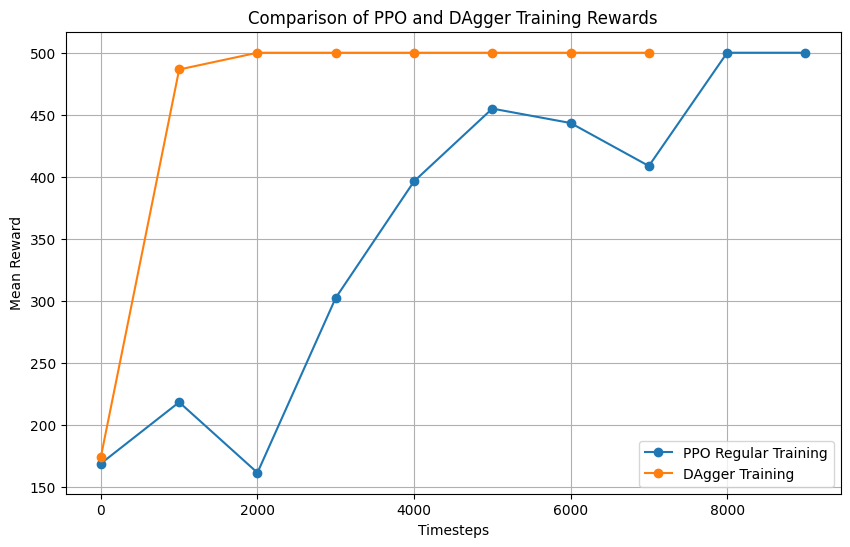

In [5]:
# Plot the rewards for Regular PPO Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="PPO Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of PPO and DAgger Training Rewards")
plt.legend()
plt.grid(True)
plt.show()


### 3. A2C Agent Training (20 Points)
After DAgger training, a third agent is trained using the **Advantage Actor-Critic (A2C)** algorithm.

In [24]:
# Create the CartPole-v1 environment with seed 4
rng = np.random.default_rng(4)
env = make_vec_env("CartPole-v1", n_envs=1, rng=rng)

model = A2C("MlpPolicy", env, verbose=1)

# Record rewards during training
regular_rewards = []

# Training loop
total_timesteps = 10000
eval_freq = 1000 
for timestep in range(0, total_timesteps, eval_freq):
    model.learn(total_timesteps=eval_freq)

    # Evaluate the model and record the mean reward over 10 episodes
    reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    regular_rewards.append(reward)

    print(f"A2C Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the model after training
model.save("CartPole_v1_A2C_model.zip")
env.close()


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 32.4     |
|    ep_rew_mean        | 32.4     |
| time/                 |          |
|    fps                | 509      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.663   |
|    explained_variance | -0.0246  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.71     |
|    value_loss         | 9.01     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 39.4     |
|    ep_rew_mean        | 39.4     |
| time/                 |          |
|    fps                | 522      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/             

In [25]:
# Create the CartPole-v1 environment
rng = np.random.default_rng()
env = make_vec_env("CartPole-v1", n_envs=1, rng=rng)

# Load the pre-trained A2C expert model onto CPU
expert = A2C.load(
    "CartPole_v1_A2C_model.zip",
    env=env,
    device="cpu",
)

# Initialize the Behavior Cloning (BC) trainer on CPU
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    rng=np.random.default_rng(0),
    device="cpu",
)

# Record rewards during DAgger training
dagger_rewards = []

with tempfile.TemporaryDirectory(prefix="dagger_a2c_") as tmpdir:
    dagger_trainer = SimpleDAggerTrainer(
        venv=env,
        scratch_dir=tmpdir,
        expert_policy=expert,
        bc_trainer=bc_trainer,
        rng=np.random.default_rng(0),
    )

    total_dagger_timesteps = 8000
    eval_freq = 1000
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        dagger_trainer.train(eval_freq)

        # Evaluate the DAgger policy (all on CPU by default)
        reward, _ = evaluate_policy(
            dagger_trainer.policy,
            env,
            n_eval_episodes=10,
        )
        dagger_rewards.append(reward)

        print(f"DAgger Training on A2C Expert - Step {timestep + eval_freq}: Mean Reward = {reward}")

env.close()


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 24        |
|    return_mean    | 18.6      |
|    return_min     | 10        |
|    return_std     | 5.28      |
---------------------------------


45batch [00:00, 162.34batch/s]
81batch [00:00, 172.55batch/s]
138batch [00:00, 178.96batch/s][A
179batch [00:01, 189.21batch/s]
184batch [00:01, 173.68batch/s]


DAgger Training on A2C Expert - Step 1000: Mean Reward = 77.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000243 |
|    entropy        | 0.243     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 87.8      |
|    loss           | 0.349     |
|    neglogp        | 0.35      |
|    prob_true_act  | 0.835     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 225       |
|    return_mean    | 105       |
|    return_min     | 51        |
|    return_std     | 62.7      |
---------------------------------


80batch [00:00, 112.62batch/s]
174batch [00:01, 157.94batch/s][A
266batch [00:02, 168.94batch/s]
341batch [00:02, 178.15batch/s]
356batch [00:02, 133.66batch/s]


DAgger Training on A2C Expert - Step 2000: Mean Reward = 464.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000108 |
|    entropy        | 0.108     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 110       |
|    loss           | 0.0498    |
|    neglogp        | 0.0499    |
|    prob_true_act  | 0.957     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 481       |
|    return_min     | 413       |
|    return_std     | 33.9      |
---------------------------------


124batch [00:02, 123.12batch/s]
246batch [00:02, 181.38batch/s]
387batch [00:03, 178.63batch/s]
485batch [00:04, 184.78batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -7.59e-05 |
|    entropy        | 0.0759    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 135       |
|    loss           | 0.0366    |
|    neglogp        | 0.0366    |
|    prob_true_act  | 0.968     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 456       |
|    return_min     | 423       |
|    return_std     | 35.7      |
---------------------------------


521batch [00:06, 43.90batch/s] 
528batch [00:06, 87.42batch/s]


DAgger Training on A2C Expert - Step 3000: Mean Reward = 490.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000107 |
|    entropy        | 0.107     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 136       |
|    loss           | 0.0673    |
|    neglogp        | 0.0674    |
|    prob_true_act  | 0.946     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 468       |
|    return_min     | 405       |
|    return_std     | 36.6      |
---------------------------------


168batch [00:02, 162.62batch/s]
342batch [00:03, 210.71batch/s]
491batch [00:03, 187.55batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.89e-05 |
|    entropy        | 0.0289    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 152       |
|    loss           | 0.0138    |
|    neglogp        | 0.0138    |
|    prob_true_act  | 0.988     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 487       |
|    return_mean    | 449       |
|    return_min     | 376       |
|    return_std     | 38.1      |
---------------------------------


527batch [00:05, 43.72batch/s] 
704batch [00:06, 174.76batch/s][A
716batch [00:06, 105.10batch/s]


DAgger Training on A2C Expert - Step 4000: Mean Reward = 473.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -5.35e-05 |
|    entropy        | 0.0535    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 158       |
|    loss           | 0.0292    |
|    neglogp        | 0.0292    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 459       |
|    return_min     | 418       |
|    return_std     | 34.2      |
---------------------------------


212batch [00:02, 182.24batch/s]
442batch [00:03, 199.52batch/s]
484batch [00:03, 200.61batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.87e-05 |
|    entropy        | 0.0287    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 171       |
|    loss           | 0.00966   |
|    neglogp        | 0.00969   |
|    prob_true_act  | 0.991     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 461       |
|    return_min     | 406       |
|    return_std     | 38.7      |
---------------------------------


648batch [00:06, 144.36batch/s]
873batch [00:07, 199.61batch/s]
884batch [00:07, 117.05batch/s]


DAgger Training on A2C Expert - Step 5000: Mean Reward = 492.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.57e-06 |
|    entropy        | 0.00357   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 178       |
|    loss           | 0.000648  |
|    neglogp        | 0.000652  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 463       |
|    return_min     | 404       |
|    return_std     | 34.4      |
---------------------------------


254batch [00:02, 195.63batch/s]
491batch [00:03, 212.27batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -6.28e-05 |
|    entropy        | 0.0628    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 188       |
|    loss           | 0.0371    |
|    neglogp        | 0.0371    |
|    prob_true_act  | 0.97      |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 464       |
|    return_min     | 401       |
|    return_std     | 44.9      |
---------------------------------


534batch [00:05, 49.66batch/s] 
786batch [00:06, 199.86batch/s][A
1000batch [00:08, 207.56batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.21e-07 |
|    entropy        | 0.000121  |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 198       |
|    loss           | 1.29e-05  |
|    neglogp        | 1.3e-05   |
|    prob_true_act  | 1         |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 454       |
|    return_min     | 406       |
|    return_std     | 31.1      |
---------------------------------


1064batch [00:09, 66.13batch/s] 
1072batch [00:09, 108.27batch/s][A


DAgger Training on A2C Expert - Step 6000: Mean Reward = 486.7


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -1.5e-05 |
|    entropy        | 0.015    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 200      |
|    loss           | 0.00633  |
|    neglogp        | 0.00635  |
|    prob_true_act  | 0.994    |
|    samples_so_far | 32       |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


306batch [00:03, 165.24batch/s]
490batch [00:04, 198.41batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.26e-08 |
|    entropy        | 1.26e-05  |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 208       |
|    loss           | 1.1e-06   |
|    neglogp        | 1.12e-06  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 486       |
|    return_min     | 457       |
|    return_std     | 18.2      |
---------------------------------


614batch [00:06, 114.18batch/s]
943batch [00:08, 197.66batch/s]
983batch [00:08, 195.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -2.78e-05 |
|    entropy        | 0.0278    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 212       |
|    loss           | 0.0111    |
|    neglogp        | 0.0111    |
|    prob_true_act  | 0.99      |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1252batch [00:11, 189.68batch/s]
1260batch [00:11, 108.54batch/s]


DAgger Training on A2C Expert - Step 7000: Mean Reward = 480.1


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -8.94e-06 |
|    entropy        | 0.00894   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 217       |
|    loss           | 0.00245   |
|    neglogp        | 0.00246   |
|    prob_true_act  | 0.998     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 480       |
|    return_min     | 421       |
|    return_std     | 30.6      |
---------------------------------


361batch [00:03, 194.94batch/s]
480batch [00:04, 189.33batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.69e-09 |
|    entropy        | 2.69e-06  |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 224       |
|    loss           | 1.91e-07  |
|    neglogp        | 1.94e-07  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 461       |
|    return_min     | 396       |
|    return_std     | 47.5      |
---------------------------------


714batch [00:06, 183.36batch/s]
990batch [00:08, 204.73batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.19e-06 |
|    entropy        | 0.00119   |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 228       |
|    loss           | 0.000195  |
|    neglogp        | 0.000196  |
|    prob_true_act  | 1         |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 476       |
|    return_min     | 388       |
|    return_std     | 44.3      |
---------------------------------


1078batch [00:10, 80.79batch/s]
1440batch [00:11, 193.50batch/s][A
1444batch [00:11, 120.48batch/s]


DAgger Training on A2C Expert - Step 8000: Mean Reward = 473.3


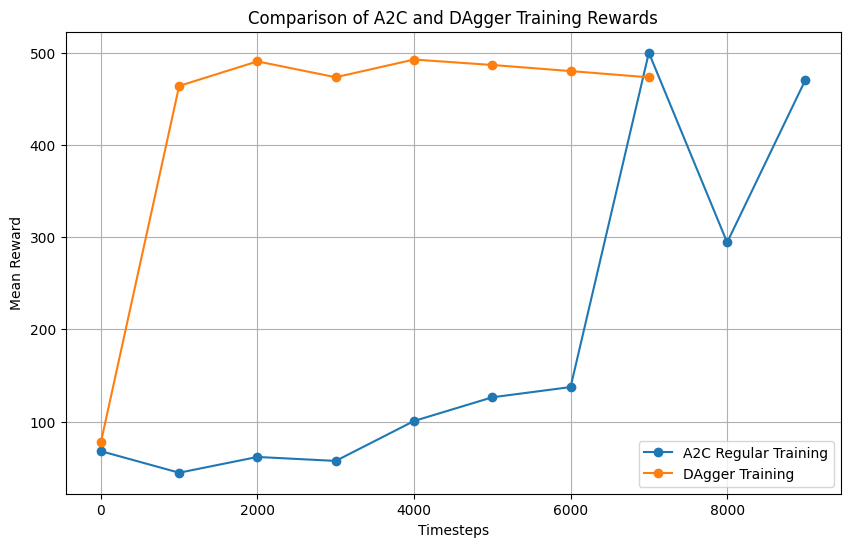

In [26]:
# Plot the rewards for Regular A2C Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="A2C Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")

plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of A2C and DAgger Training Rewards")
plt.legend()

plt.grid(True)
plt.show()

# Training a GAIL Model Using an Expert Policy

In this section, we walk through the process of setting up and training a **Generative Adversarial Imitation Learning (GAIL)** model using a pre-trained expert in environments such as `CartPole-v1`, `Pendulum-v0`, and `BipedalWalker-v3`.

The full pipeline includes:
- Setting up directories and configurations,
- Loading and validating the environment,
- Initializing expert and GAIL models,
- Training GAIL using the expert’s behavior,
- Saving the final results and model weights.

## Summary

This pipeline implements a complete imitation learning workflow using GAIL. The process involves:
- Setting up a Gym-compatible environment,
- Loading a pre-trained expert model,
- Training a GAIL agent to mimic the expert,
- Storing the training results and model artifacts.

By following this structure, we can compare GAIL's performance to reinforcement learning approaches like PPO or A2C, and evaluate the efficiency of learning from demonstrations.

---


In [2]:
import os
import shutil

# Source and destination
src_dir = "/kaggle/input/aida-dataset"
dst_dir = "/kaggle/working"

# Make sure source exists
if not os.path.isdir(src_dir):
    raise FileNotFoundError(f"Could not find source folder: {src_dir}")

# Copy everything over
for item in os.listdir(src_dir):
    s = os.path.join(src_dir, item)
    d = os.path.join(dst_dir, item)
    if os.path.isdir(s):
        # If dest exists, remove it first so our copy is fresh
        if os.path.exists(d):
            shutil.rmtree(d)
        shutil.copytree(s, d)
    else:
        shutil.copy2(s, d)

# Verification: list out what’s now in /kaggle/working
moved = os.listdir(dst_dir)
print(f"Successfully moved {len(moved)} items into {dst_dir}:")
for fname in moved:
    print("  ", fname)


Successfully moved 5 items into /kaggle/working:
   experts
   .virtual_documents
   utils
   config.json
   models


In [3]:
from models.nets import Expert
from models.gail import GAIL

### **1. `setup_directories(env_name)`** (5 Points)

```python
This function handles directory setup and expert configuration:
- Creates a base checkpoint directory (`ckpts/`).
- Validates if the provided environment name is supported.
- Loads the expert model configuration from a JSON file.
- Creates a subdirectory for storing environment-specific checkpoints.

**Purpose:** Prepare the file system and load settings for the expert model.

In [4]:
def setup_directories(env_name):
    # 1) Ensure the base checkpoint directory exists
    ckpt_base = "ckpts"
    os.makedirs(ckpt_base, exist_ok=True)

    # 2) Validate the environment
    supported_envs = ["CartPole-v1", "Pendulum-v0", "BipedalWalker-v3"]
    if env_name not in supported_envs:
        print(f"[ERROR] Unsupported environment '{env_name}'.")
        return None, None, None

    # 3) Locate the expert’s checkpoint directory
    expert_ckpt_dir = os.path.join("experts", env_name)
    if not os.path.isdir(expert_ckpt_dir):
        raise FileNotFoundError(f"Expert directory not found: {expert_ckpt_dir}")

    # 4) Load the expert’s JSON config
    config_path = os.path.join(expert_ckpt_dir, "model_config.json")
    if not os.path.isfile(config_path):
        raise FileNotFoundError(f"Expert config file not found: {config_path}")
    with open(config_path, "r") as f:
        expert_config = json.load(f)

    # 5) Create (or reuse) the environment-specific checkpoint folder
    ckpt_env_dir = os.path.join(ckpt_base, env_name)
    os.makedirs(ckpt_env_dir, exist_ok=True)

    return expert_ckpt_dir, expert_config, ckpt_env_dir


### **2. `load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)`** (10 Points)
- Loads a general configuration file (`config.json`) that contains training hyperparameters specific to the environment.
- Saves these configurations to the current checkpoint folder for logging and reproducibility.

**Purpose:** Fetch and store hyperparameters needed for training the GAIL model.

In [5]:
def load_and_save_configs(expert_ckpt_path, ckpt_path, env_name):
    # Path to the global config file
    global_config_path = "config.json"
    if not os.path.isfile(global_config_path):
        raise FileNotFoundError(f"Global config file not found at {global_config_path}")

    # Load the global config, which should contain per-environment hyperparameters
    with open(global_config_path, "r") as f:
        global_config = json.load(f)

    # Extract the config specific to this environment
    if env_name not in global_config:
        raise KeyError(f"No hyperparameters for '{env_name}' found in {global_config_path}")
    config = global_config[env_name]

    # Save the per-env config into the checkpoint directory for reproducibility
    os.makedirs(ckpt_path, exist_ok=True)
    save_path = os.path.join(ckpt_path, "config.json")
    with open(save_path, "w") as f:
        json.dump(config, f, indent=4)

    return config


### **3. `setup_environment(env_name)`** (10 Points)

- Initializes the chosen environment using OpenAI Gym.
- Extracts the dimensions of the state and action spaces.
- Checks whether the action space is discrete (e.g., CartPole) or continuous (e.g., Pendulum).

**Purpose:** Provide key environment information for model initialization.


In [6]:
def setup_environment(env_name):
    # Initialize the Gym environment
    env = gym.make(env_name)
    # Reset once to ensure it works and to get a sample observation
    obs, _ = env.reset()

    # Determine state dimension
    obs_space = env.observation_space
    if isinstance(obs_space, gym.spaces.Box):
        # Continuous observation space
        state_dim = int(np.prod(obs_space.shape))
    elif isinstance(obs_space, gym.spaces.Discrete):
        # Discrete observation space
        state_dim = obs_space.n
    else:
        raise NotImplementedError(f"Unsupported observation space type: {type(obs_space)}")

    # Determine action dimension and whether discrete
    act_space = env.action_space
    if isinstance(act_space, gym.spaces.Discrete):
        discrete = True
        action_dim = act_space.n
    elif isinstance(act_space, gym.spaces.Box):
        discrete = False
        action_dim = int(np.prod(act_space.shape))
    else:
        raise NotImplementedError(f"Unsupported action space type: {type(act_space)}")

    return env, state_dim, action_dim, discrete


### **4. `setup_device()`** (+5 Points for running on GPU)
- Checks if a GPU (`cuda`) is available.
- Falls back to CPU if GPU is not detected.

**Purpose:** Ensure the training runs on the optimal hardware available.


In [7]:
import torch

def setup_device():
    """
    Returns the best available device ('cuda' if GPU is available, otherwise 'cpu').
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"[INFO] Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("[INFO] CUDA not available, falling back to CPU.")
    return device


### **5. `initialize_expert(...)`** (15 Points)

- Initializes an `Expert` model using its architecture config and environment dimensions.
- Loads pre-trained policy weights (`policy.ckpt`) from the expert checkpoint.

**Purpose:** Prepare a high-performance expert model whose behavior GAIL will learn to imitate.

In [8]:
def initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device):
    """
    Initializes an Expert policy with the given architecture and loads its pretrained weights.
    
    Args:
        expert_ckpt_path (str): Path to the expert checkpoint directory.
        state_dim (int): Dimension of the environment state.
        action_dim (int): Dimension (or number) of actions.
        discrete (bool): Whether the action space is discrete.
        expert_config (dict): Architecture hyperparameters for the Expert network.
        device (torch.device): Device to load the model onto.
    
    Returns:
        expert (Expert): The loaded Expert model in evaluation mode.
    """
    # Instantiate the Expert network and move it to the target device
    expert = Expert(state_dim, action_dim, discrete, **expert_config).to(device)
    
    # Construct the path to the saved policy weights
    policy_path = os.path.join(expert_ckpt_path, "policy.ckpt")
    if not os.path.isfile(policy_path):
        raise FileNotFoundError(f"Expert policy checkpoint not found at {policy_path}")
    
    # Load the pretrained weights
    state_dict = torch.load(policy_path, map_location=device)
    expert.pi.load_state_dict(state_dict)
    
    # Set to evaluation mode
    expert.eval()
    
    return expert


### **6. `initialize_gail_model(...)`** (15 Points)
- Initializes the `GAIL` model using environment specs and configuration parameters.
- The model includes a policy, value function, and discriminator.

**Purpose:** Set up the GAIL agent that learns by interacting with the environment and distinguishing between expert and learner behavior.


In [9]:
def initialize_gail_model(state_dim, action_dim, discrete, config, device):
    """
    Initializes the GAIL agent with policy, value function, and discriminator.
    
    Args:
        state_dim (int): Dimension of the environment state.
        action_dim (int): Dimension (or number) of actions.
        discrete (bool): Whether the action space is discrete.
        config (dict): Hyperparameters for GAIL (e.g., learning rates, network sizes).
        device (torch.device): Device to place the model on.
    
    Returns:
        model (GAIL): The initialized GAIL agent.
    """
    # Instantiate the GAIL model and move it to the target device
    model = GAIL(state_dim, action_dim, discrete, config).to(device)
    return model


### **7. `train_gail_model(model, env, expert)`** (20 Points)
- Runs the training loop for the GAIL agent.
- The GAIL model tries to imitate the expert by fooling the discriminator into thinking the learner’s actions come from the expert.

**Purpose:** Train the policy using imitation learning via adversarial training.


In [10]:
def train_gail_model(model, env, expert):
    """
    Trains the GAIL agent to imitate the expert policy.
    
    Args:
        model (GAIL): The GAIL agent initialized via initialize_gail_model.
        env (gym.Env): The environment to interact with.
        expert (Expert): The pretrained expert policy.
    
    Returns:
        results: Training logs and metrics returned by the GAIL training procedure.
    """
    # Run the adversarial training loop
    results = model.train(env, expert)
    return results


### **8. `save_results_and_checkpoints(...)`** (+5 Points)
- Saves training results (e.g., episode returns) as a pickle file.
- Saves the weights of the trained components: policy, value network, and discriminator.

**Purpose:** Store the final model and results for evaluation and future use.


In [11]:
def save_results_and_checkpoints(ckpt_path, results, model):
    """
    Saves training results and model checkpoints for policy, value network, and discriminator.
    
    Args:
        ckpt_path (str): Directory where checkpoints and results will be saved.
        results: Object containing training metrics (e.g., episode returns).
        model (GAIL): The trained GAIL model with attributes `pi`, `v`, and `d`.
    """
    # Ensure checkpoint directory exists
    os.makedirs(ckpt_path, exist_ok=True)

    # Save training results
    results_path = os.path.join(ckpt_path, "results.pkl")
    with open(results_path, "wb") as f:
        pickle.dump(results, f)

    # Save policy network weights
    if hasattr(model, "pi"):
        policy_path = os.path.join(ckpt_path, "policy.ckpt")
        torch.save(model.pi.state_dict(), policy_path)

    # Save value network weights
    if hasattr(model, "v"):
        value_path = os.path.join(ckpt_path, "value.ckpt")
        torch.save(model.v.state_dict(), value_path)

    # Save discriminator weights
    if hasattr(model, "d"):
        disc_path = os.path.join(ckpt_path, "discriminator.ckpt")
        torch.save(model.d.state_dict(), disc_path)


### 9. **`main()`** (25 Points)
- The main function orchestrates the entire GAIL training process.
- It calls all the above functions in sequence to set up directories, load configurations, initialize models, train the GAIL agent, and save results.


In [12]:
# Part 10: Main Function

def main(env_name):
    # Set up directories and validate environment
    expert_ckpt_path, expert_config, ckpt_path = setup_directories(env_name)
    if not expert_ckpt_path:
        return
    # Load and save configuration files
    config = load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)
    # Set up environment and get dimensions
    env, state_dim, action_dim, discrete = setup_environment(env_name)
    # Set up the device (CPU or GPU)
    device = setup_device()
    # Initialize expert model
    expert = initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device)
    # Initialize GAIL model
    model = initialize_gail_model(state_dim, action_dim, discrete, config, device)
    # Train the GAIL model
    results = train_gail_model(model, env, expert)
    # Close the environment
    env.close()
    # Save results and model checkpoints
    save_results_and_checkpoints(ckpt_path, results, model)

### 10. **`run_gail(env_name)`** (+5 Points if using parse_args)
- This function serves as the entry point for running the GAIL training pipeline.
- It accepts an environment name as input and executes the entire GAIL training process.


In [24]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--env_name",
        type=str,
        default="CartPole-v1",
        help=(
            "Type the environment name to run. "
            "The possible environments are [CartPole-v1, Pendulum-v0, BipedalWalker-v3]"
        ),
    )
    # Use parse_known_args so Jupyter/Colab flags are ignored
    args, _ = parser.parse_known_args()

    main(args.env_name)


[INFO] Using GPU: Tesla T4
Expert Reward Mean: 500.0
Iterations: 1,   Reward Mean: 22.942528735632184
Iterations: 2,   Reward Mean: 23.63095238095238
Iterations: 3,   Reward Mean: 36.666666666666664
Iterations: 4,   Reward Mean: 43.369565217391305
Iterations: 5,   Reward Mean: 68.85714285714286
Iterations: 6,   Reward Mean: 132.42857142857142
Iterations: 7,   Reward Mean: 151.53846153846155
Iterations: 8,   Reward Mean: 198.88888888888889
Iterations: 9,   Reward Mean: 160.66666666666666
Iterations: 10,   Reward Mean: 196.8
Iterations: 11,   Reward Mean: 192.6
Iterations: 12,   Reward Mean: 236.25
Iterations: 13,   Reward Mean: 351.4
Iterations: 14,   Reward Mean: 378.4
Iterations: 15,   Reward Mean: 471.25
Iterations: 16,   Reward Mean: 389.8
Iterations: 17,   Reward Mean: 363.8
Iterations: 18,   Reward Mean: 227.875
Iterations: 19,   Reward Mean: 210.0
Iterations: 20,   Reward Mean: 276.42857142857144
Iterations: 21,   Reward Mean: 302.0
Iterations: 22,   Reward Mean: 336.0
Iterations

In [ ]:
import os
import json
import pickle
from models.nets import Expert
from models.gail import GAIL
import gymnasium as gym
import numpy as np
import torch
import tempfile


lambdas   = [0.0, 0.001]
env_names = ["CartPole-v1", "Pendulum-v0", "BipedalWalker-v3"]

for lam in lambdas:
    for env_name in env_names:
        print(f"\n=== Running GAIL on {env_name} with lambda = {lam} ===")
        
        # 1) Prepare directories and expert config
        expert_ckpt_path, expert_config, ckpt_path = setup_directories(env_name)
        config = load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)
        
        # 2) Override lambda in the config
        config['lambda'] = lam
        
        # 3) Create a subfolder for this lambda value
        run_ckpt = os.path.join(ckpt_path, f"lambda_{lam}")
        os.makedirs(run_ckpt, exist_ok=True)
        # Save the overridden config
        with open(os.path.join(run_ckpt, "config.json"), "w") as f:
            json.dump(config, f, indent=4)
        
        # 4) Map Pendulum-v0 → Pendulum-v1 for gym.make
        actual_env_id = "Pendulum-v1" if env_name == "Pendulum-v0" else env_name
        
        # 5) Initialize env, device, expert, and GAIL model
        #    Note: setup_environment now takes actual_env_id
        env, state_dim, action_dim, discrete = setup_environment(actual_env_id)
        device = setup_device()
        expert = initialize_expert(
            expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device
        )
        model = initialize_gail_model(state_dim, action_dim, discrete, config, device)
        
        # 6) Train GAIL
        results = train_gail_model(model, env, expert)
        env.close()
        
        # 7) Save results and checkpoints
        save_results_and_checkpoints(run_ckpt, results, model)
        print(f"Results and models saved to: {run_ckpt}")



=== Running GAIL on CartPole-v1 with lambda = 0.0 ===
[INFO] Using GPU: Tesla T4
Expert Reward Mean: 500.0
Iterations: 1,   Reward Mean: 22.908045977011493
Iterations: 2,   Reward Mean: 24.679012345679013
Iterations: 3,   Reward Mean: 34.258620689655174
Iterations: 4,   Reward Mean: 37.96078431372549
Iterations: 5,   Reward Mean: 51.81578947368421
Iterations: 6,   Reward Mean: 82.70833333333333
Iterations: 7,   Reward Mean: 100.0
Iterations: 8,   Reward Mean: 157.5
Iterations: 9,   Reward Mean: 198.2
Iterations: 10,   Reward Mean: 206.22222222222223
Iterations: 11,   Reward Mean: 193.1
Iterations: 12,   Reward Mean: 254.85714285714286
Iterations: 13,   Reward Mean: 198.3
Iterations: 14,   Reward Mean: 207.66666666666666
Iterations: 15,   Reward Mean: 237.0
Iterations: 16,   Reward Mean: 236.125
Iterations: 17,   Reward Mean: 214.44444444444446
Iterations: 18,   Reward Mean: 215.55555555555554
Iterations: 19,   Reward Mean: 252.57142857142858
Iterations: 20,   Reward Mean: 252.14285714

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Settings
lambdas = [0.0, 0.001]
env_names = ["CartPole-v1", "Pendulum-v0", "BipedalWalker-v3"]
eval_freq = 1000  # timesteps between evaluations

for env_name in env_names:
    plt.figure(figsize=(8, 6))
    
    # Plot for each λ
    for lam in lambdas:
        # Path to this run's results.pkl
        run_ckpt = os.path.join("/content/ckpts", env_name, f"lambda_{lam}")
        results_path = os.path.join(run_ckpt, "results.pkl")
        
        # Load expert mean and GAIL stats
        with open(results_path, "rb") as f:
            expert_mean, gail_stats = pickle.load(f)
        
        # Unpack means and stds
        if isinstance(gail_stats, dict):
            means = np.array(gail_stats["mean"])
            stds  = np.array(gail_stats["std"])
        else:
            means, stds = map(np.array, gail_stats)
        
        # X-axis: timesteps
        steps = np.arange(1, len(means) + 1) * eval_freq
        
        # Plot mean line
        plt.plot(steps, means, linewidth=2, label=f"λ={lam} Mean")
        # Plot ±1 STD band
        plt.fill_between(
            steps,
            means - stds,
            means + stds,
            alpha=0.2,
            label=f"λ={lam} ±1 STD"
        )
    
    # Plot the expert baseline (constant)
    plt.axhline(
        y=expert_mean,
        color="black",
        linestyle="--",
        linewidth=2,
        label="Expert Mean"
    )
    
    # Formatting
    plt.title(f"GAIL Performance on {env_name}", fontsize=14)
    plt.xlabel("Training Timesteps", fontsize=12)
    plt.ylabel("Mean Episode Reward", fontsize=12)
    plt.legend(fontsize=10, loc="best")
    plt.grid(which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


in balaei ha kheili tool mikeshid dige velesh kardam hamoon ye modeli ke khodet gozashti ro gozashtam manam dar nahayat

CODE BALA ROO 3 TA MOHIT 6 TA RUN MIGIRE KE KHEILI TOOL MIKESHE VALI CODE PAEIN ROO HAMOON YE MOHITE KE KHODETAM ZADE BOODI

In [14]:
import os
import json
import pickle
from models.nets import Expert
from models.gail import GAIL
import gymnasium as gym
import numpy as np
import torch
import tempfile


lambdas   = [0.0]
env_names = ["CartPole-v1"]

for lam in lambdas:
    for env_name in env_names:
        print(f"\n=== Running GAIL on {env_name} with lambda = {lam} ===")
        
        # 1) Prepare directories and expert config
        expert_ckpt_path, expert_config, ckpt_path = setup_directories(env_name)
        config = load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)
        
        # 2) Override lambda in the config
        config['lambda'] = lam
        
        # 3) Create a subfolder for this lambda value
        run_ckpt = os.path.join(ckpt_path, f"lambda_{lam}")
        os.makedirs(run_ckpt, exist_ok=True)
        # Save the overridden config
        with open(os.path.join(run_ckpt, "config.json"), "w") as f:
            json.dump(config, f, indent=4)
        
        # 4) Map Pendulum-v0 → Pendulum-v1 for gym.make
        actual_env_id = "Pendulum-v1" if env_name == "Pendulum-v0" else env_name
        
        # 5) Initialize env, device, expert, and GAIL model
        #    Note: setup_environment now takes actual_env_id
        env, state_dim, action_dim, discrete = setup_environment(actual_env_id)
        device = setup_device()
        expert = initialize_expert(
            expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device
        )
        model = initialize_gail_model(state_dim, action_dim, discrete, config, device)
        
        # 6) Train GAIL
        results = train_gail_model(model, env, expert)
        env.close()
        
        # 7) Save results and checkpoints
        save_results_and_checkpoints(run_ckpt, results, model)
        print(f"Results and models saved to: {run_ckpt}")



=== Running GAIL on CartPole-v1 with lambda = 0.0 ===
[INFO] Using GPU: Tesla T4
Expert Reward Mean: 500.0
Iterations: 1,   Reward Mean: 22.625
Iterations: 2,   Reward Mean: 24.9
Iterations: 3,   Reward Mean: 31.171875
Iterations: 4,   Reward Mean: 39.56
Iterations: 5,   Reward Mean: 49.38461538461539
Iterations: 6,   Reward Mean: 78.64
Iterations: 7,   Reward Mean: 102.73684210526316
Iterations: 8,   Reward Mean: 181.1818181818182
Iterations: 9,   Reward Mean: 239.75
Iterations: 10,   Reward Mean: 354.6
Iterations: 11,   Reward Mean: 260.0
Iterations: 12,   Reward Mean: 500.0
Iterations: 13,   Reward Mean: 351.4
Iterations: 14,   Reward Mean: 352.4
Iterations: 15,   Reward Mean: 379.8
Iterations: 16,   Reward Mean: 436.5
Iterations: 17,   Reward Mean: 447.75
Iterations: 18,   Reward Mean: 458.0
Iterations: 19,   Reward Mean: 297.0
Iterations: 20,   Reward Mean: 233.125
Iterations: 21,   Reward Mean: 279.14285714285717
Iterations: 22,   Reward Mean: 373.4
Iterations: 23,   Reward Mean

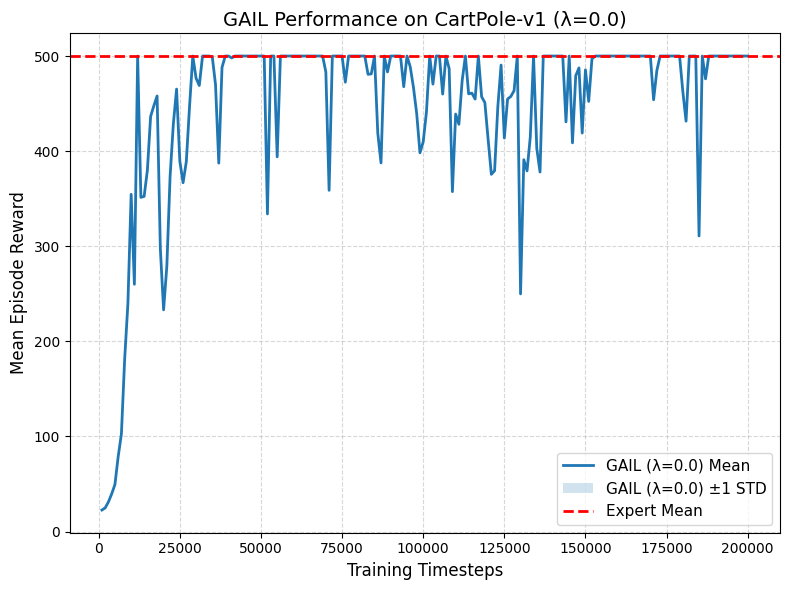

In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Settings
env_name = "CartPole-v1"
lam = 0.0
eval_freq = 1000  # timesteps between evaluations

# Path to this run's results.pkl
ckpt_dir = os.path.join("ckpts", env_name, f"lambda_{lam}")
results_path = os.path.join(ckpt_dir, "results.pkl")

# Load expert mean reward and raw GAIL training data
with open(results_path, "rb") as f:
    expert_mean, gail_data = pickle.load(f)

# Determine means and stds depending on format of gail_data
if isinstance(gail_data, dict):
    # If it's a dict with "mean" and "std" keys
    means = np.array(gail_data["mean"])
    stds  = np.array(gail_data["std"])
else:
    # Assume it's a list of per-episode returns per evaluation point
    arr = np.array(gail_data)
    if arr.ndim == 2:
        # shape (n_eval_points, n_episodes)
        means = arr.mean(axis=1)
        stds  = arr.std(axis=1)
    elif arr.ndim == 1:
        # Already one mean per eval
        means = arr
        stds  = np.zeros_like(arr)
    else:
        raise ValueError(f"Unexpected shape for gail_data: {arr.shape}")

# X‑axis: training timesteps
steps = np.arange(1, len(means) + 1) * eval_freq

# Plot
plt.figure(figsize=(8, 6))
plt.plot(steps, means, linewidth=2, label=f"GAIL (λ={lam}) Mean")
plt.fill_between(
    steps,
    means - stds,
    means + stds,
    alpha=0.2,
    label=f"GAIL (λ={lam}) ±1 STD"
)
plt.axhline(
    y=expert_mean,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Expert Mean"
)

plt.title(f"GAIL Performance on {env_name} (λ={lam})", fontsize=14)
plt.xlabel("Training Timesteps", fontsize=12)
plt.ylabel("Mean Episode Reward", fontsize=12)
plt.legend(fontsize=11)
plt.grid(which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


provide a plot like below:

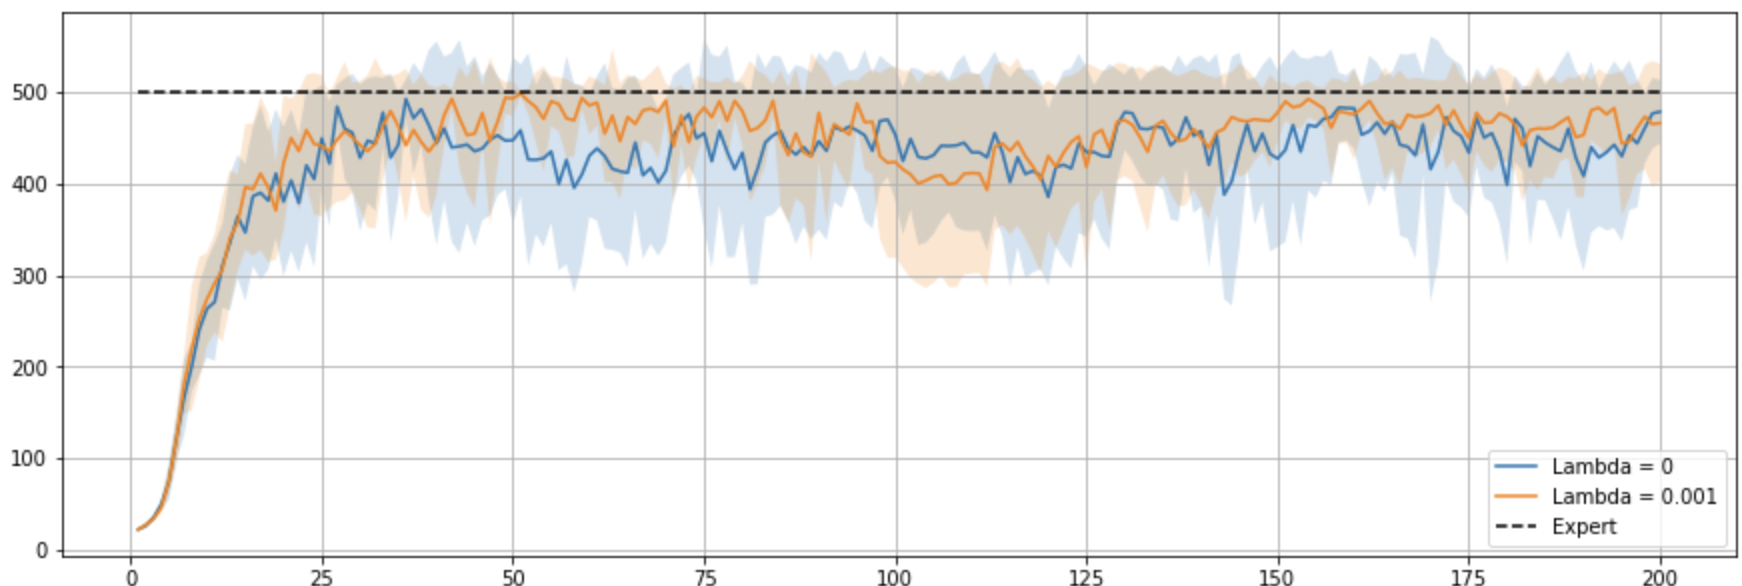